In [1]:
# Import necessary libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
from textblob import TextBlob  # For sentiment analysis
import time  # To add delay between requests

# Base URL of the webpage to scrape
base_url = 'https://markets.businessinsider.com/news/nvda-stock?p='

# Define columns for the DataFrame
columns = ['Datetime', 'title', 'source', 'link', 'top_sentiment', 'sentiment_score']
df = pd.DataFrame(columns=columns)

# Number of pages to scrape (adjust based on how many pages cover 90 days)
pages_to_scrape = 100  # Adjust this value based on the website's pagination

# Loop through the pages
for page in range(1, pages_to_scrape + 1):
    print(f"Scraping page {page}...")

    # Generate the URL for the current page
    url = base_url + str(page)

    # Make a GET request to fetch the raw HTML content
    response = requests.get(url)
    html = response.text

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html, 'lxml')

    # Locate news articles on the page
    articles = soup.find_all('div', class_='latest-news__story')

    # Extract details for each article
    for article in articles:
        # Extract details for each article
        datetime = article.find('time', class_='latest-news__date').get('datetime') if article.find('time', class_='latest-news__date') else None
        title = article.find('a', class_='news-link').text.strip() if article.find('a', class_='news-link') else None
        source = article.find('span', class_='latest-news__source').text.strip() if article.find('span', class_='latest-news__source') else None
        link = article.find('a', class_='news-link').get('href') if article.find('a', class_='news-link') else None

        # Perform sentiment analysis using TextBlob
        if title:
            analysis = TextBlob(title)
            sentiment_score = analysis.sentiment.polarity  # Sentiment polarity (-1 to 1)
            if sentiment_score > 0:
                top_sentiment = 'Positive'
            elif sentiment_score < 0:
                top_sentiment = 'Negative'
            else:
                top_sentiment = 'Neutral'
        else:
            sentiment_score = 0
            top_sentiment = 'Unknown'

        # Append the extracted details to the DataFrame
        df = pd.concat([df, pd.DataFrame([[datetime, title, source, link, top_sentiment, sentiment_score]], columns=columns)], ignore_index=True)

    # Delay to avoid overloading the server (respectful scraping)
    time.sleep(2)

print("Scraping complete.")

# Save the DataFrame to a CSV file in Colab
df.to_csv('/content/nvda_stock_news_90days_sentiment.csv', index=False)

print("CSV file has been saved as 'nvda_stock_news_90days_sentiment.csv' in the Colab environment.")


Scraping page 1...


<ipython-input-1-9260366487f7>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[datetime, title, source, link, top_sentiment, sentiment_score]], columns=columns)], ignore_index=True)


Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping page 49...
Scraping page 50...
Scraping page 51...
Scraping

In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime

# Load the news dataset
file_path = 'nvda_stock_news_90days_sentiment.csv'
news_data = pd.read_csv(file_path)

# Convert 'datetime' column to a pandas datetime object
news_data['Datetime'] = pd.to_datetime(news_data['Datetime'])

# Fetch Nvidia stock price data for the relevant time period
start_date = news_data['Datetime'].min().strftime('%Y-%m-%d')
end_date = news_data['Datetime'].max().strftime('%Y-%m-%d')
nvda_data = yf.download('NVDA', start=start_date, end=end_date, interval='1h')

# Reset the index and ensure timestamps are timezone-naive
nvda_data = nvda_data.reset_index()
# Change 'Datetime' to 'Date'
nvda_data['Datetime'] = nvda_data['Datetime'].dt.tz_localize(None)  # Remove timezone info

# Function to find the closest stock data row
def get_closest_stock_data(news_time, stock_data):
    closest_row = stock_data.iloc[(stock_data['Datetime'] - news_time).abs().argsort()[:1]]
    if not closest_row.empty:
        return (
            closest_row['Open'].values[0],
            closest_row['Close'].values[0],
            closest_row['High'].values[0],
            closest_row['Low'].values[0],
            closest_row['Volume'].values[0]
        )
    return (None, None, None, None, None)

# Ensure news_data datetime is timezone-naive
news_data['Datetime'] = news_data['Datetime'].dt.tz_localize(None)

# Apply function to extract stock data
stock_columns = ['stock_open', 'stock_close', 'stock_high', 'stock_low', 'stock_volume']
news_data[stock_columns] = news_data['Datetime'].apply(
    lambda x: pd.Series(get_closest_stock_data(x, nvda_data))
)

# Save the updated dataset
output_file = 'nvda_news_with_full_stock_data.csv'
news_data.to_csv(output_file, index=False)

print(f"Updated dataset saved to: {output_file}")

<ipython-input-2-bc214d3eb9dd>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_data['Datetime'] = pd.to_datetime(news_data['Datetime'])
[*********************100%***********************]  1 of 1 completed


Updated dataset saved to: nvda_news_with_full_stock_data.csv


In [3]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the news dataset
file_path = 'nvda_stock_news_90days_sentiment.csv'
news_data = pd.read_csv(file_path)

# Convert 'datetime' column to a pandas datetime object
news_data['Datetime'] = pd.to_datetime(news_data['Datetime'])

# Load FinBERT model and tokenizer
finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Define a function to perform FinBERT sentiment analysis
def finbert_sentiment_analysis(text):
    if not text:
        return 'Neutral', 0.0  # Return Neutral for empty text
    inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = finbert_model(**inputs)
    scores = torch.softmax(outputs.logits, dim=1).detach().numpy()[0]
    sentiments = ["Negative", "Neutral", "Positive"]
    sentiment = sentiments[scores.argmax()]
    sentiment_score = scores.max()
    return sentiment, sentiment_score

# Apply FinBERT sentiment analysis to each title
news_data[['finbert_sentiment', 'finbert_score']] = news_data['title'].apply(
    lambda x: pd.Series(finbert_sentiment_analysis(x))
)

# Fetch Nvidia stock price data for the relevant time period
start_date = news_data['Datetime'].min().strftime('%Y-%m-%d')
end_date = news_data['Datetime'].max().strftime('%Y-%m-%d')
nvda_data = yf.download('NVDA', start=start_date, end=end_date, interval='1h')

# Reset the index and ensure timestamps are timezone-naive
nvda_data = nvda_data.reset_index()
nvda_data['Datetime'] = nvda_data['Datetime'].dt.tz_localize(None)  # Remove timezone info

# Function to find the closest stock data row
def get_closest_stock_data(news_time, stock_data):
    closest_row = stock_data.iloc[(stock_data['Datetime'] - news_time).abs().argsort()[:1]]
    if not closest_row.empty:
        return (
            closest_row['Open'].values[0],
            closest_row['Close'].values[0],
            closest_row['High'].values[0],
            closest_row['Low'].values[0],
            closest_row['Volume'].values[0]
        )
    return (None, None, None, None, None)

# Ensure news_data datetime is timezone-naive
news_data['Datetime'] = news_data['Datetime'].dt.tz_localize(None)

# Apply function to extract stock data
stock_columns = ['stock_open', 'stock_close', 'stock_high', 'stock_low', 'stock_volume']
news_data[stock_columns] = news_data['Datetime'].apply(
    lambda x: pd.Series(get_closest_stock_data(x, nvda_data))
)

# Save the updated dataset
output_file = 'nvda_news_with_finbert_and_stock_data.csv'
news_data.to_csv(output_file, index=False)

print(f"Updated dataset saved to: {output_file}")


<ipython-input-3-f86aa3fcf94f>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_data['Datetime'] = pd.to_datetime(news_data['Datetime'])
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

[*********************100%***********************]  1 of 1 completed


Updated dataset saved to: nvda_news_with_finbert_and_stock_data.csv


In [4]:
import pandas as pd

# Load the dataset
file_path = 'nvda_news_with_finbert_and_stock_data.csv'
news_data = pd.read_csv(file_path)

# Step 1: Convert 'datetime' column to pandas datetime
news_data['Datetime'] = pd.to_datetime(news_data['Datetime'])

# Step 2: Convert stock columns to numeric values
stock_columns = ['stock_open', 'stock_close', 'stock_high', 'stock_low', 'stock_volume']
for col in stock_columns:
    # Remove any potential brackets from string values and convert to float
    news_data[col] = news_data[col].apply(lambda x: float(str(x).strip('[]')) if pd.notnull(x) else None)

# Step 3: Handle missing values
# Drop rows with missing essential data
essential_columns = ['Datetime', 'finbert_sentiment', 'finbert_score', 'stock_open', 'stock_close']
news_data = news_data.dropna(subset=essential_columns)

# Step 4: Reset index after cleaning
news_data.reset_index(drop=True, inplace=True)

# Step 5: Check for duplicate rows and remove them
news_data = news_data.drop_duplicates()

# Save the cleaned dataset
cleaned_file = 'nvda_news_with_finbert_and_stock_data_cleaned.csv'
news_data.to_csv(cleaned_file, index=False)

print(f"Cleaned dataset saved to: {cleaned_file}")


Cleaned dataset saved to: nvda_news_with_finbert_and_stock_data_cleaned.csv


In [5]:
import pandas as pd
df = '/content/nvda_news_with_finbert_and_stock_data_cleaned.csv'
news_data = pd.read_csv(df)

# Display an overview of the dataset
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Datetime           4999 non-null   object 
 1   title              4999 non-null   object 
 2   source             4999 non-null   object 
 3   link               4999 non-null   object 
 4   top_sentiment      4999 non-null   object 
 5   sentiment_score    4999 non-null   float64
 6   finbert_sentiment  4999 non-null   object 
 7   finbert_score      4999 non-null   float64
 8   stock_open         4999 non-null   float64
 9   stock_close        4999 non-null   float64
 10  stock_high         4999 non-null   float64
 11  stock_low          4999 non-null   float64
 12  stock_volume       4999 non-null   float64
dtypes: float64(7), object(6)
memory usage: 507.8+ KB


In [6]:
import pandas as pd

# Load the cleaned dataset
file_path = 'nvda_news_with_finbert_and_stock_data_cleaned.csv'
data = pd.read_csv(file_path)

# Ensure 'datetime' is a datetime object
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Sort by datetime for sequential processing
data = data.sort_values('Datetime').reset_index(drop=True)

# Stock Price Features
data['pct_change'] = ((data['stock_close'] - data['stock_open']) / data['stock_open']) * 100
data['intraday_volatility'] = data['stock_high'] - data['stock_low']
data['price_range'] = data['stock_high'] - data['stock_low']

# Volume Features
data['volume_change'] = data['stock_volume'].pct_change()

# Sentiment Features
data['lag_1_sentiment'] = data['finbert_score'].shift(1)
data['sentiment_avg_3'] = data['finbert_score'].rolling(window=3).mean()
data['weighted_sentiment'] = data['finbert_score'] * data['stock_volume']

# Interaction Features
data['price_sentiment_interaction'] = (data['stock_close'] - data['stock_open']) * data['finbert_score']
data['volume_sentiment_interaction'] = data['stock_volume'] * data['finbert_score']

# Time Features
data['day_of_week'] = data['Datetime'].dt.dayofweek

# Drop rows with NaN values caused by lagged or rolling operations
data = data.dropna().reset_index(drop=True)

# Save the updated dataset
output_file = 'nvda_news_with_optimized_features.csv'
data.to_csv(output_file, index=False)

print(f"Optimized feature-engineered dataset saved to: {output_file}")


Optimized feature-engineered dataset saved to: nvda_news_with_optimized_features.csv


In [7]:
import numpy as np
import pandas as pd

# Load the feature-engineered dataset
file_path = 'nvda_news_with_optimized_features.csv'  # Replace with your dataset file path
data = pd.read_csv(file_path)

# Ensure data is sorted by datetime for sequential processing
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.sort_values(by='Datetime').reset_index(drop=True)

# Define rolling window parameters
train_window = 14  # Number of days for training
test_window = 1    # Number of days for testing
step_size = 1      # Step size for rolling the window

# Extract features and target
features = [
    'stock_open', 'stock_high', 'stock_low', 'stock_volume',
    'pct_change', 'intraday_volatility', 'price_range', 'volume_change',
    'lag_1_sentiment', 'sentiment_avg_3', 'weighted_sentiment',
    'price_sentiment_interaction', 'volume_sentiment_interaction'
]
target = 'stock_close'

# Prepare rolling windows
rolling_splits = []
for start in range(0, len(data) - train_window - test_window + 1, step_size):
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Extract training and testing data
    X_train = data[features].iloc[train_start:train_end].values
    y_train = data[target].iloc[train_start:train_end].values
    X_test = data[features].iloc[test_start:test_end].values
    y_test = data[target].iloc[test_start:test_end].values

    rolling_splits.append((X_train, y_train, X_test, y_test))

print(f"Created {len(rolling_splits)} rolling windows for training and testing.")


Created 4983 rolling windows for training and testing.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 8194.1357 - mae: 83.9972 - val_loss: 4558.6836 - val_mae: 59.0940
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3521.7754 - mae: 49.3693 - val_loss: 1455.3896 - val_mae: 32.2373
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1335.4127 - mae: 31.0816 - val_loss: 876.5588 - val_mae: 24.9538
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 670.1919 - mae: 20.3387 - val_loss: 197.2250 - val_mae: 9.4722
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 295.4660 - mae: 13.3494 - val_loss: 83.3395 - val_mae: 5.7527
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 195.8621 - mae: 10.7111 - val_loss: 38.3474 - val_mae: 3.8152
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 148.4995 - mae: 9.3183 - val_loss: 22.4107 - val_mae: 2.7234
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 135.9179 - mae: 9.0079 - val_loss: 62.5325 - val_mae: 7.1454
Epoch 9/20
20

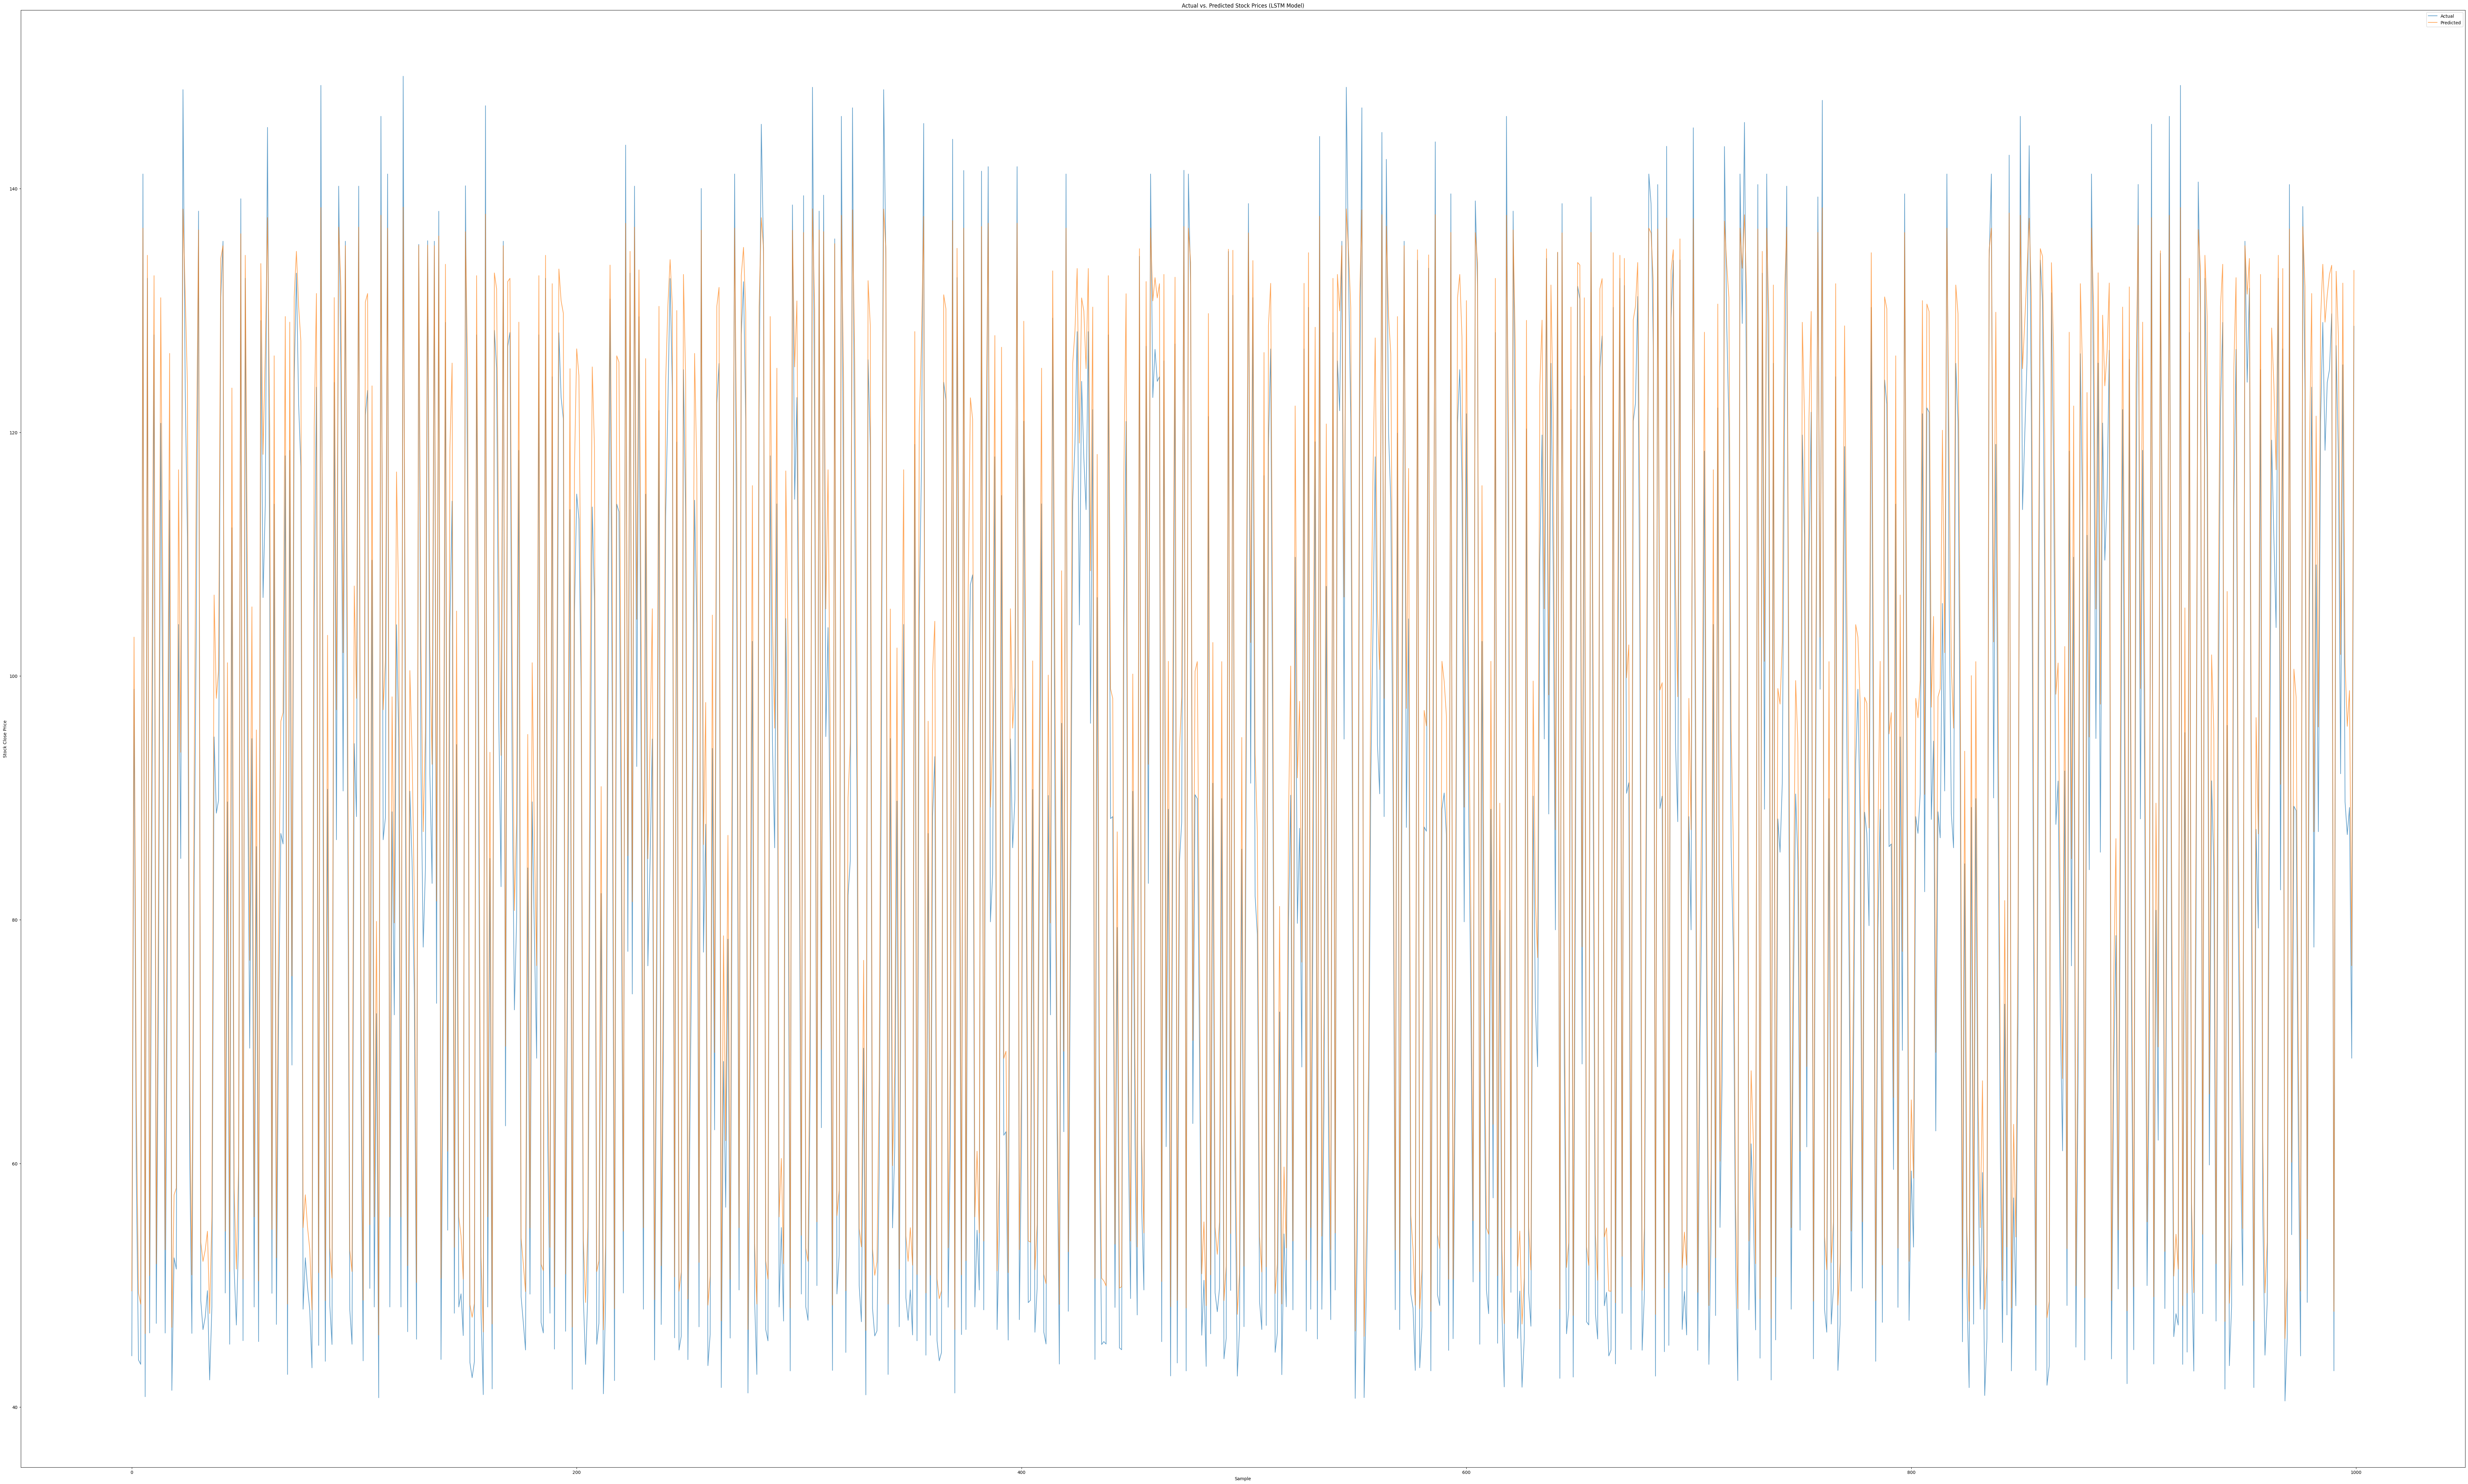

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Select top features
top_features = ['stock_high', 'stock_low', 'stock_open']

# Prepare data for training
X = data[top_features]
y = data['stock_close']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train.values, axis=1)  # Add time step dimension
X_test = np.expand_dims(X_test.values, axis=1)

# Define LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = create_lstm_model(input_shape)

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Make predictions
predictions = model.predict(X_test)

# Plot actual vs. predicted stock prices
import matplotlib.pyplot as plt
plt.figure(figsize=(100, 60))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions.flatten(), label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs. Predicted Stock Prices (LSTM Model)')
plt.xlabel('Sample')
plt.ylabel('Stock Close Price')
plt.show()


Epoch 1/50


<ipython-input-9-1f73c648b942>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['stock_moving_avg'] = X['stock_open'].rolling(window=5, min_periods=1).mean()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0771 - mae: 0.1766 - val_loss: 3.2575e-04 - val_mae: 0.0123 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - mae: 0.0403 - val_loss: 0.0010 - val_mae: 0.0237 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - mae: 0.0352 - val_loss: 4.7212e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - mae: 0.0338 - val_loss: 6.4500e-04 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - mae: 0.0307 - val_loss: 0.0012 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 6/50
 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mae: 0.0290
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - mae: 0.0290 - val_loss: 3.2545e-04 - val_mae: 0.0121 - learning_rate: 0.

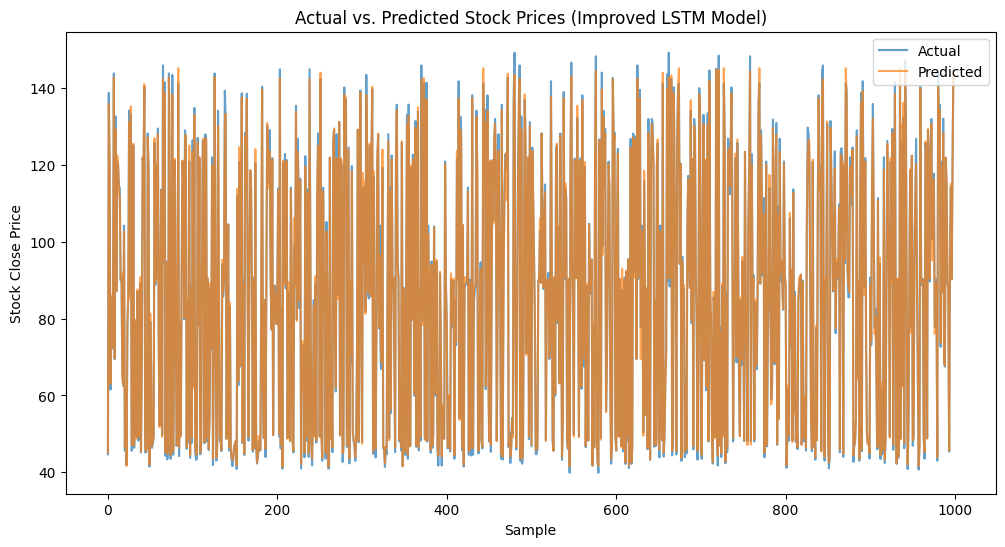

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Select features and target
top_features = ['stock_high', 'stock_low', 'stock_open']
X = data[top_features]
y = data['stock_close']

# Add moving average as a feature
X['stock_moving_avg'] = X['stock_open'].rolling(window=5, min_periods=1).mean()

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Prepare timesteps for LSTM (e.g., use 5 timesteps)
timesteps = 5

def create_sequences(features, target, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(features) - timesteps):
        X_seq.append(features[i:i + timesteps])
        y_seq.append(target[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, timesteps)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Define improved LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Create model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = create_lstm_model(input_shape)

# Callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Make predictions and inverse transform
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plot actual vs. predicted stock prices
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', alpha=0.7)
plt.plot(predictions.flatten(), label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs. Predicted Stock Prices (Improved LSTM Model)')
plt.xlabel('Sample')
plt.ylabel('Stock Close Price')
plt.show()


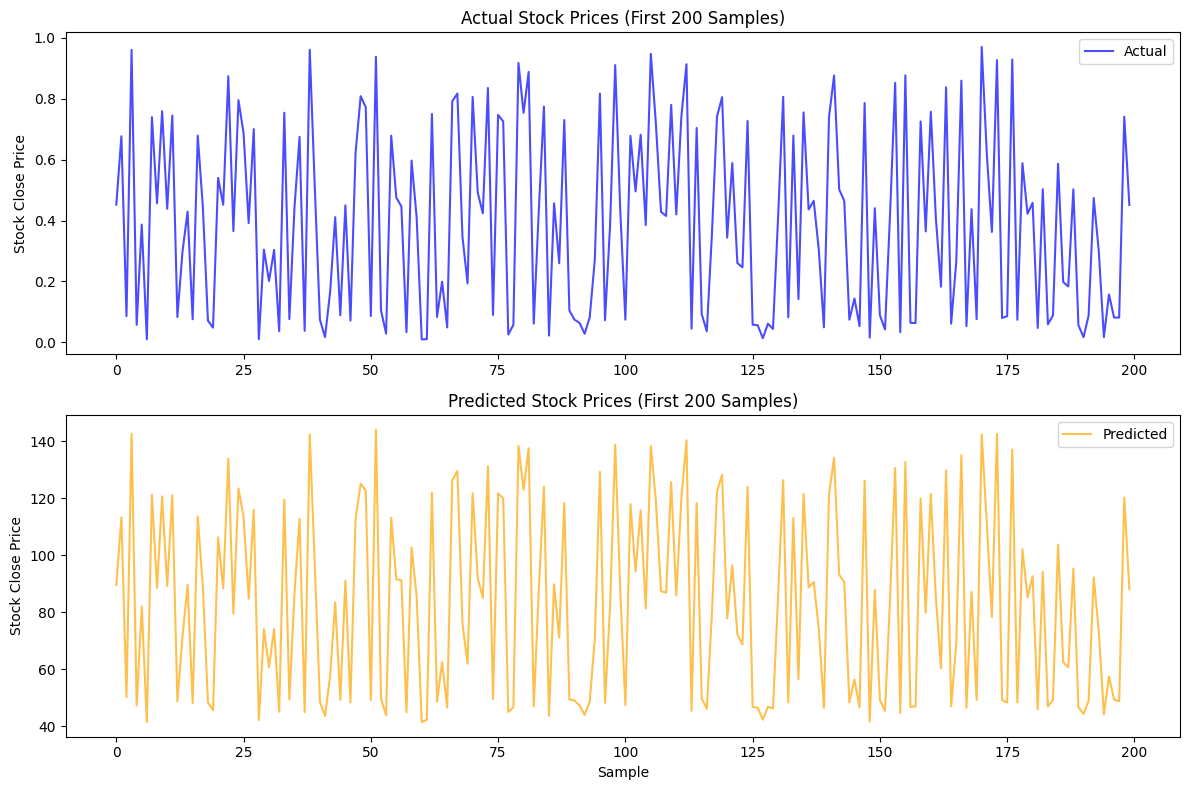

In [10]:
# Slice the data for the first 200 samples
y_test_slice = y_test[200:400] # Directly slice y_test as an ndarray
predictions_slice = predictions.flatten()[200:400]

# Plot actual vs. predicted stock prices using subplots
plt.figure(figsize=(12, 8))

# Subplot 1: Actual stock prices
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(y_test_slice, label='Actual', color='blue', alpha=0.7)
plt.title('Actual Stock Prices (First 200 Samples)')
plt.ylabel('Stock Close Price')
plt.legend()

# Subplot 2: Predicted stock prices
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(predictions_slice, label='Predicted', color='orange', alpha=0.7)
plt.title('Predicted Stock Prices (First 200 Samples)')
plt.xlabel('Sample')
plt.ylabel('Stock Close Price')
plt.legend()

# Show the plots
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0628 - mae: 0.1690 - val_loss: 0.0688 - val_mae: 0.2249 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - mae: 0.0575 - val_loss: 0.0636 - val_mae: 0.2166 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - mae: 0.0566 - val_loss: 0.0281 - val_mae: 0.1436 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056 - mae: 0.0542 - val_loss: 0.0248 - val_mae: 0.1325 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - mae: 0.0533 - val_loss: 0.0068 - val_mae: 0.0604 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - mae: 0.0420 - val_loss: 0.0035 - val_mae: 0.0454 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0030 - mae: 0.0401 - val_loss: 0.0079 - val_mae: 0.0698 - learning_rate: 0.0

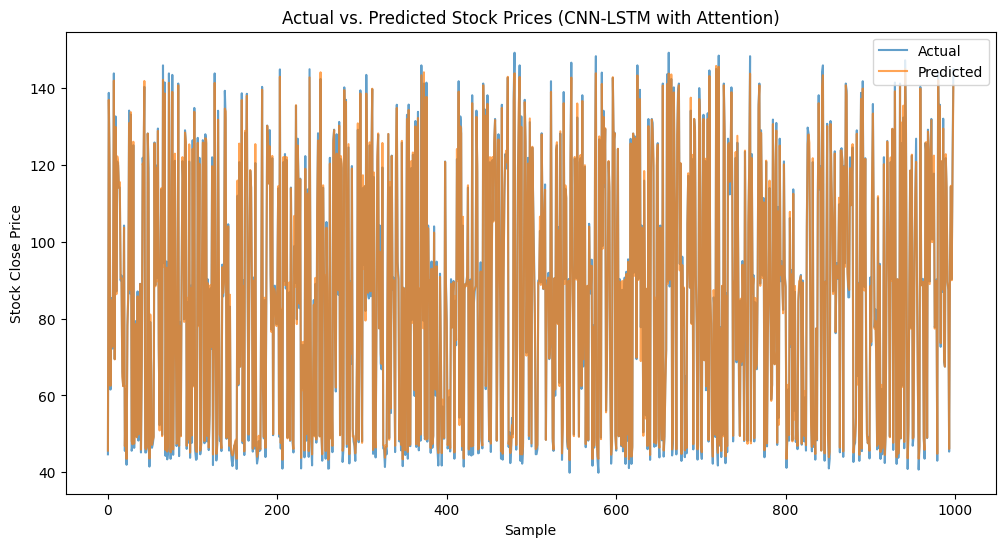

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Add, BatchNormalization, Attention
import tensorflow as tf

# Define a hybrid CNN-LSTM model with Attention
def create_hybrid_model(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layer to extract short-term patterns
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = BatchNormalization()(cnn)

    # LSTM layers for sequential learning
    lstm = LSTM(128, activation='tanh', return_sequences=True)(cnn)
    lstm = Dropout(0.3)(lstm)
    lstm = LSTM(64, activation='tanh', return_sequences=True)(lstm)
    lstm = Dropout(0.3)(lstm)

    # Attention mechanism
    attention = tf.keras.layers.Attention()([lstm, lstm])
    attention = Flatten()(attention)

    # Fully connected layers
    dense = Dense(64, activation='relu')(attention)
    dense = Dropout(0.3)(dense)
    dense = Dense(32, activation='relu')(dense)
    outputs = Dense(1)(dense)  # Regression output

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Define input shape (timesteps, features)
input_shape = (X_train.shape[1], X_train.shape[2])

# Create and compile the model
model = create_hybrid_model(input_shape)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Predictions and inverse transform
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', alpha=0.7)
plt.plot(predictions.flatten(), label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs. Predicted Stock Prices (CNN-LSTM with Attention)')
plt.xlabel('Sample')
plt.ylabel('Stock Close Price')
plt.show()


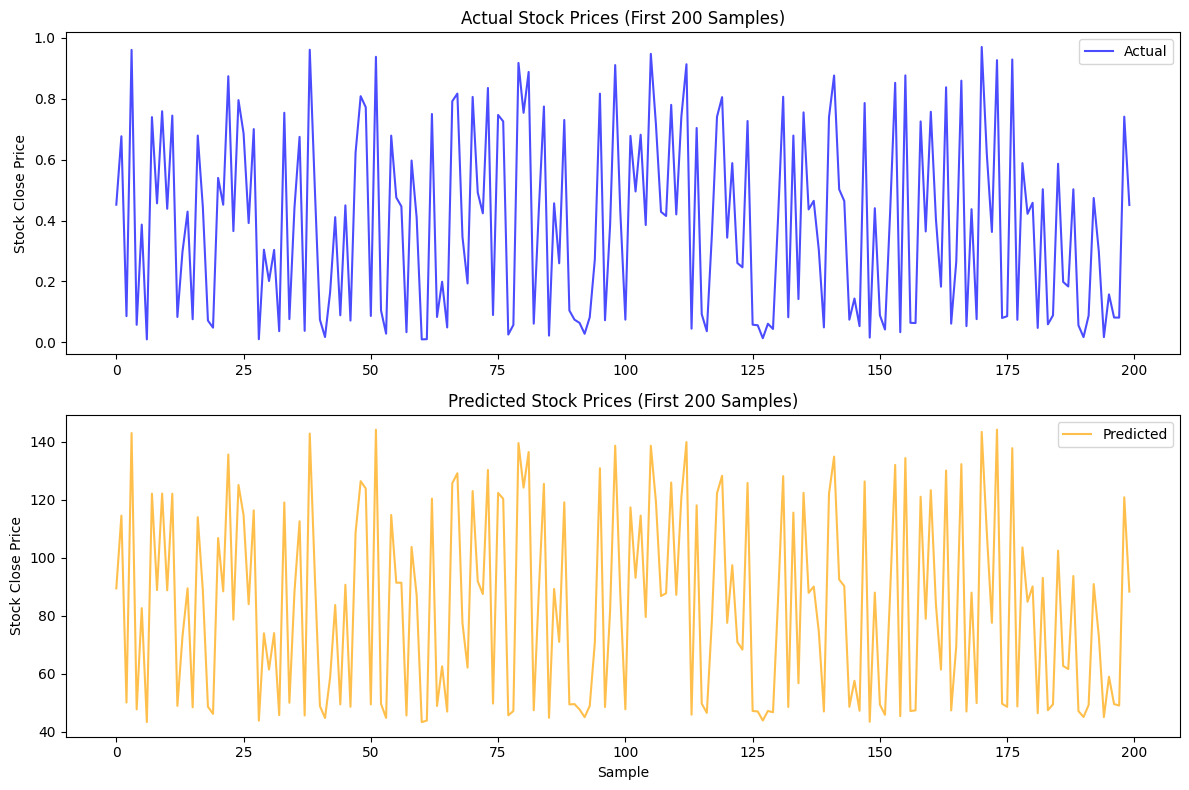

In [15]:
# Slice the data for the first 200 samples
y_test_slice = y_test[200:400] # Remove .values
predictions_slice = predictions.flatten()[200:400]

# Plot actual vs. predicted stock prices using subplots
plt.figure(figsize=(12, 8))

# Subplot 1: Actual stock prices
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(y_test_slice, label='Actual', color='blue', alpha=0.7)
plt.title('Actual Stock Prices (First 200 Samples)')
plt.ylabel('Stock Close Price')
plt.legend()

# Subplot 2: Predicted stock prices
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(predictions_slice, label='Predicted', color='orange', alpha=0.7)
plt.title('Predicted Stock Prices (First 200 Samples)')
plt.xlabel('Sample')
plt.ylabel('Stock Close Price')
plt.legend()

# Show the plots
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()